<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Change_Point_Detection/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point Detection

In [1]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00


In [39]:
# Libraries
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

# MatPlotLib style
plt.style.use('ggplot')

## 0. Signal Creation

In [40]:
# generate signal
n_samples, dim, sigma = 1000, 3, 5
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# 1D signal
d1_signal = [signal[i][0] for i in range(len(signal))]
x = list(range(len(d1_signal)))

In [41]:
# Dataset 0

lists_d0 = []
for j in range(0,4501,500):
  lists_d0.append([i for i in range(j,j+500,20)])
for lista in lists_d0:
  lista.reverse()
lists_d0.reverse()

lists_d0_nr = []
for j in range(0,5001,500):
  lists_d0_nr.append(np.repeat(j,50).tolist())
lists_d0_nr.reverse()

final_list_d0 = []
for i in range(min(len(lists_d0),len(lists_d0_nr))):
  final_list_d0 = final_list_d0 + lists_d0_nr[i] + lists_d0[i]
final_list_d0 = final_list_d0 + lists_d0_nr[-1]

In [42]:
len(lists_d0[0])

25

In [43]:
# Dataset 1

lists_d1 = []
for j in range(11):
  lists_d1.append([2000+5*i for i in range(51)])

lists_d1_r = []
for j in range(10):
  l = [2000+5*i for i in range(0,51,2)]
  l.reverse()
  lists_d1_r.append(l)
del l

final_list_d1 = []
for i in range(min(len(lists_d1),len(lists_d1_r))):
  final_list_d1 = final_list_d1 + lists_d1[i] + lists_d1_r[i]
final_list_d1 = final_list_d1 + lists_d1[-1]

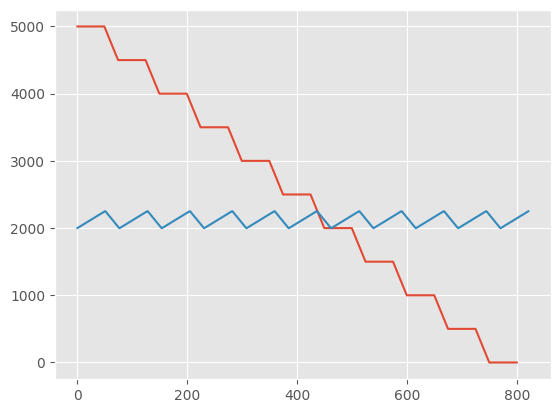

In [44]:
y_d0 = np.array(final_list_d0)
y_d1 = np.array(final_list_d1)
x_d0 = [i for i in range(len(y_d0))]
x_d1 = [i for i in range(len(y_d1))]
plt.plot(x_d0,y_d0)
plt.plot(x_d1,y_d1)

## 1. Costs function

In [ ]:
# Least absolute derivation (L1)
def l1_cost(signal, start, end):
  subset = signal[start:end]
  med = np.median(subset, axis=0)
  return abs(subset - med).sum()

# Least squared deviation (L2)
def l2_cost(signal, start, end):
  subset = signal[start:end]
  return subset.var(axis=0).sum()*(end - start)

## 2. Optimal changing point

In [ ]:
def optimal_cp(signal, start, end):
        segment_cost = l2_cost(signal, start, end)
        if np.isinf(segment_cost) and segment_cost < 0:  # if cost is -inf
            return None, 0
        gain_list = list()
        for bkp in range(start, end, 5):
            if bkp - start >= 1 and end - bkp >= 1:
                gain = (
                    segment_cost - l2_cost(signal, start, bkp) - l2_cost(signal, bkp, end)
                )
                gain_list.append((gain, bkp))
        try:
            gain, bkp = max(gain_list)
        except ValueError:  # if empty sub_sampling
            return None, 0
        return gain_list, bkp, gain

In [ ]:
y_ = np.array(np.repeat(100,50).tolist() + np.repeat(0,50).tolist())
x_ = range(len(y_))

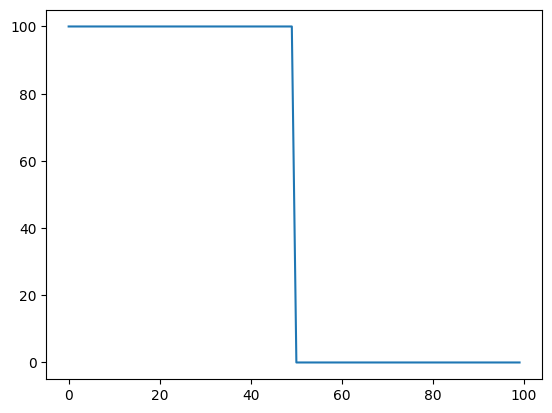

In [ ]:
plt.plot(x_,y_)

In [ ]:
rev = [i for i in range(30,50,4)]
rev.reverse()
y__ = np.array([i for i in range(50)] + rev + [i for i in range(30,80)])
x__ = np.array([i for i in range(len(y__))])

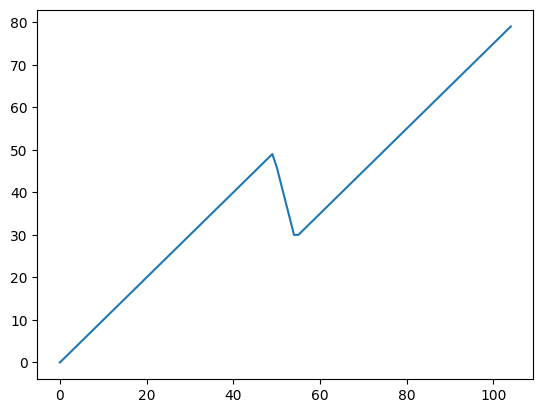

In [ ]:
plt.plot(x__,y__)

In [ ]:
optimal_cp(y__, 0, len(y__)-1)

([(7209.406080031091, 5),
  (13205.451104746324, 10),
  (18002.737143474496, 15),
  (21619.342948717953, 20),
  (24077.92417234664, 25),
  (25407.259615384617, 30),
  (25644.469760312153, 35),
  (24838.275240384617, 40),
  (23053.9121577575, 45),
  (20380.778133903135, 50),
  (20713.850524475525, 55),
  (23228.509615384617, 60),
  (24840.144230769234, 65),
  (25463.68818681319, 70),
  (25036.759615384617, 75),
  (23512.572115384617, 80),
  (20855.347850678732, 85),
  (17037.259615384613, 90),
  (12036.33856275304, 95),
  (5835.009615384617, 100)],
 35,
 25644.469760312153)

In [ ]:
max(gain_list[1:])

(0.0, 5)